# Routine to read in available sounding data and interpolate to regular height interval (all years)


Data source: https://weather.uwyo.edu/upperair/sounding.html

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 12})
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta

# meteorology - specific
from metpy.calc import (relative_humidity_from_dewpoint, 
                        mixing_ratio_from_relative_humidity,
                        vapor_pressure)
from metpy.units import units
from siphon.simplewebservice.wyoming import WyomingUpperAir

import sys
sys.path.append('./scripts/')

from LIB_dates import generate_date_list
from LIB_request_WUA_sounding import check_for_WUA_soundings
from LIB_sounding_analysis import (interpolate_soundings, 
                                   saturation_vaporpressures_from_temperature,
                                  relative_humidity_from_temperature_pressure)
from LIB_sounding_date_checks import grab_sounding_dates

### Specify parameters to retreive sounding data

season should be either 'winter', 'spring', 'summer', 'autumn', or 'all' for all year

In [2]:
# specify year, season, sounding hours
# specify site and height range
#===============================
years = np.arange(1997,2017)
season = 'winter'
hours = [12]

station = 'PABR'

max_height = 6*units.kilometer
min_height =  0*units.kilometer
bin_width = 0.1*units.kilometer
#===============================

# julian day ranges for each season
season_bounds = {}
season_bounds['winter'] = {'start': 0,   'end': 91}
season_bounds['spring'] = {'start': 91,  'end': 182}
season_bounds['summer'] = {'start': 182, 'end': 274}
season_bounds['autumn'] = {'start': 274, 'end': 366}

### Retrieve and interpolate data

In [3]:
for yy, year in enumerate(years):

    # find all julian days (/hours) with soundings for given year
    doy, sou, year = grab_sounding_dates(csv=f'./sounding_checks/checked_{year}0101Z00_{year}1231Z23_hourly6.csv', hours=hours)
    days_with_soundings = doy[sou==1]

    # crop days to specified season
    if str(season) == 'all':
        doy_season = days_with_soundings
    else:
        doy_season = doy[(doy>(season_bounds[season]['start']))&
                         (doy<=(season_bounds[season]['end']))]
        
    # run through all days in season
    for ii in range(len(doy_season)):

        # create date
        jdoy = int(doy_season[ii]) # round down to julian day
        hour = int(24*(doy_season[ii]%1)) # grab hours
        date = datetime.strptime(f'{year}-{jdoy}-{hour}', '%Y-%j-%H')

        # print every 20 dates
        if ii%50 == 0:
            print(date)

        # request data using siphon
        # try request multiple times in case there is error with first
        num_tries = 5
        for attempt in range(num_tries):
            try:
                df = WyomingUpperAir.request_data(date, station)
                worked = True
            except:
                worked = False
            if worked == True:
                break
        if worked == False:
            df = []
            print(f"No data available for {date}")

        # if data request was succesful:
        # pull out T, Td, H and calculate RH
        #-----------------------------------
        if len(df) > 0:
            
            # assign units to all data
            height = df['height'].values * units(df.units['height']).to(units.kilometer)
            temperature = df['temperature'].values * units(df.units['temperature'])
            dewpoint = df['dewpoint'].values * units(df.units['dewpoint'])
            pressure = df['pressure'].values * units(df.units['pressure'])

            # crop all to below 10 km
            H = height[height < 10*units.kilometer]
            T = temperature[height < 10*units.kilometer]
            Td = dewpoint[height < 10*units.kilometer]
            P = pressure[height < 10*units.kilometer]

            # calculate relative humiditys
            #----------------------------

            # using metpy:
            RH = relative_humidity_from_dewpoint(T, Td).to('percent')

            # using own fuctions from formulas found in literature (and some metpy)
            RH_liq, RH_ice = relative_humidity_from_temperature_pressure(P, Td, T, method = 'improved_magnus_1996')
            

        # interpolate 
        #-----------------------------------  

        if yy == 0 and ii == 0:
            all_RH = np.zeros([int(((max_height-min_height)/bin_width).magnitude), len(doy_season), len(years)])
            all_T = np.zeros([int(((max_height-min_height)/bin_width).magnitude), len(doy_season), len(years)])
            all_RH_liq = np.zeros([int(((max_height-min_height)/bin_width).magnitude), len(doy_season), len(years)])
            all_RH_ice = np.zeros([int(((max_height-min_height)/bin_width).magnitude), len(doy_season), len(years)])
            
                    
        try:
            new_RH = []
            new_T = []
            new_RH_ice = []
            new_RH_liq = []
            
            if len(df) > 0:
            
                [new_T, new_RH, new_RH_liq, new_RH_ice], new_H, edges = interpolate_soundings(variable = [T, RH, RH_liq, RH_ice], heights = H, 
                                                                      bin_width = bin_width, min_height = min_height, 
                                                                      max_height = max_height, method = 'mean', 
                                                                      suppress_plots = True, suppress_prints = True)
                if len(new_RH) > 0:
                    for rr in range(int(((max_height-min_height)/bin_width).magnitude)):
                        all_RH[rr, ii, yy] = new_RH[rr].magnitude
                        all_T[rr, ii, yy] = new_T[rr].magnitude
                        all_RH_liq[rr, ii, yy] = new_RH_liq[rr].magnitude
                        all_RH_ice[rr, ii, yy] = new_RH_ice[rr].magnitude
                else:
                    for rr in range(int(((max_height-min_height)/bin_width).magnitude)):
                        all_RH[rr, ii, yy] = np.nan
                        all_T[rr, ii, yy] = np.nan
                        all_RH_liq[rr, ii, yy] = np.nan
                        all_RH_ice[rr, ii, yy] = np.nan
            
            else:
                
                for rr in range(int(((max_height-min_height)/bin_width).magnitude)):
                    all_RH[rr, ii, yy] = np.nan
                    all_T[rr, ii, yy] = np.nan
                    all_RH_liq[rr, ii, yy] = np.nan
                    all_RH_ice[rr, ii, yy] = np.nan
                    

        except:
            print(f'  - issue with retrieval on {date}')
            
            # fill entries with nans if issue arises with data retreival
            for rr in range(int(((max_height-min_height)/bin_width).magnitude)):
                all_RH[rr, ii, yy] = np.nan
                all_T[rr, ii, yy] = np.nan
                all_RH_liq[rr, ii, yy] = np.nan
                all_RH_ice[rr, ii, yy] = np.nan


assign RH ice values to nan if T > 0 C
for ii in range(np.shape(all_RH_ice)[0]):
    for jj in range(np.shape(all_RH_ice)[1]):
        for kk in range(np.shape(all_RH_ice)[2]):
            if all_T[ii][jj][kk] > 0:
                all_RH_ice[ii][jj][kk] = np.nan
                


1997-01-01 12:00:00
No data available for 1997-01-13 12:00:00
No data available for 1997-01-23 12:00:00
No data available for 1997-02-13 12:00:00
1997-02-20 12:00:00
No data available for 1997-03-02 12:00:00
No data available for 1997-03-04 12:00:00
  - issue with retrieval on 1997-03-27 12:00:00
1998-01-01 12:00:00
No data available for 1998-01-23 12:00:00
  - issue with retrieval on 1998-02-03 12:00:00
1998-02-20 12:00:00
1999-01-01 12:00:00
  - issue with retrieval on 1999-01-10 12:00:00
No data available for 1999-01-30 12:00:00
No data available for 1999-02-01 12:00:00
No data available for 1999-02-03 12:00:00
1999-02-20 12:00:00
No data available for 1999-02-20 12:00:00
No data available for 1999-02-28 12:00:00
No data available for 1999-03-24 12:00:00
2000-01-01 12:00:00


/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/pint/numpy_func.py:768: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


  - issue with retrieval on 2000-01-08 12:00:00
No data available for 2000-01-14 12:00:00
No data available for 2000-02-11 12:00:00
2000-02-20 12:00:00
No data available for 2000-03-09 12:00:00
No data available for 2000-03-10 12:00:00
2001-01-01 12:00:00
No data available for 2001-01-01 12:00:00
No data available for 2001-01-08 12:00:00
No data available for 2001-01-09 12:00:00
No data available for 2001-01-22 12:00:00
2001-02-20 12:00:00
No data available for 2001-03-04 12:00:00
No data available for 2001-03-18 12:00:00
2002-01-01 12:00:00
2002-02-20 12:00:00
2003-01-01 12:00:00
2003-02-20 12:00:00
2004-01-01 12:00:00
No data available for 2004-02-03 12:00:00
No data available for 2004-02-11 12:00:00
2004-02-20 12:00:00
  - issue with retrieval on 2004-03-21 12:00:00


/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/pint/numpy_func.py:768: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


  - issue with retrieval on 2004-03-24 12:00:00


/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/pint/numpy_func.py:768: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


  - issue with retrieval on 2004-03-30 12:00:00
2005-01-01 12:00:00
2005-02-20 12:00:00
No data available for 2005-03-12 12:00:00
No data available for 2005-03-13 12:00:00
2006-01-01 12:00:00
No data available for 2006-02-12 12:00:00
  - issue with retrieval on 2006-02-13 12:00:00
2006-02-20 12:00:00
No data available for 2006-03-20 12:00:00
2007-01-01 12:00:00
No data available for 2007-02-10 12:00:00
2007-02-20 12:00:00
  - issue with retrieval on 2007-03-17 12:00:00
2008-01-01 12:00:00
No data available for 2008-02-02 12:00:00
2008-02-20 12:00:00
No data available for 2008-03-15 12:00:00
2009-01-01 12:00:00
2009-02-20 12:00:00
2010-01-01 12:00:00
  - issue with retrieval on 2010-01-19 12:00:00
2010-02-20 12:00:00
  - issue with retrieval on 2010-02-27 12:00:00
2011-01-01 12:00:00
  - issue with retrieval on 2011-02-16 12:00:00
2011-02-20 12:00:00
2012-01-01 12:00:00
2012-02-20 12:00:00
No data available for 2012-02-29 12:00:00
No data available for 2012-03-01 12:00:00
No data availa

### save dataset

In [5]:
# save to dataset
ds = xr.Dataset(
    data_vars=dict(RH_metpy =(["h", "doy", "year"], all_RH, {"units": "%"}),
                   RH_liq =(["h", "doy", "year"], all_RH_liq, {"units": "%"}),
                   RH_ice =(["h", "doy", "year"], all_RH_ice, {"units": "%"}),
                   T = (["h", "doy", "year"], all_T, {"units": "degC"})),
    coords=dict(h=(["h"], new_H.magnitude, {"units": "km"}),
                year=(["year"], years),
                doy=(["doy"], doy_season)),
    attrs=dict(description=f"{season}, {years[0]} - {years[-1]}, hours: {hours} Z"))

savename = f'./data/{season}_{years[0]}-{years[-1]}_v4.nc'
print(f'save as: {savename}')
ds.to_netcdf(path=savename, mode='w', format="NETCDF4")    

save as: ./data/winter_1997-2016_v4.nc


### Plot seasonal relative humidity and temperatures, averaged across analyzed years

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_42994/3759393644.py:9: UserWarning: No contour levels were found within the data range.
  ax.contour(DOY, H, np.nanmean(all_RH_liq, axis=2), colors='k', linewidths=0.5, levels=[90,95,100])


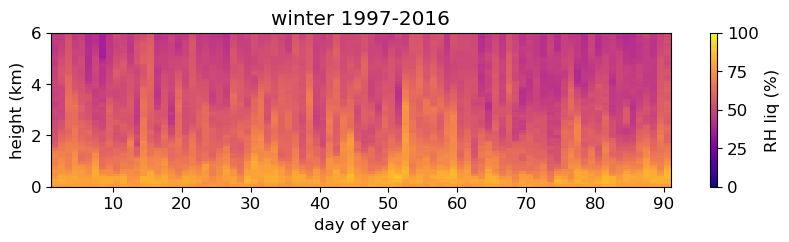

RH ice assigned to nan when T > 0 degC


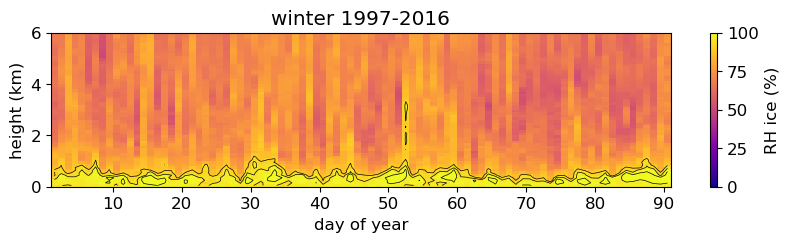

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_42994/3759393644.py:33: UserWarning: No contour levels were found within the data range.
  ax.contour(DOY, H, np.nanmean(all_T, axis=2), colors='k', linewidths=0.5, levels=[0], vmin=-50, vmax=0)


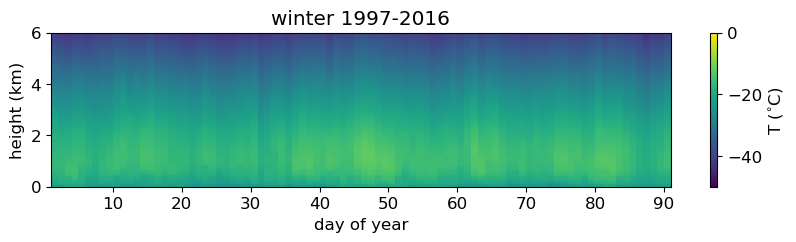

In [6]:
# grid data 
DOY, H = np.meshgrid(doy_season, new_H.magnitude)

# relative humidity w.r.t. liquid
#--------------------------------
fig, ax = plt.subplots(figsize=(10,2))
ax.set_facecolor('lightgray')
rh = ax.pcolormesh(DOY, H, np.nanmean(all_RH_liq, axis=2), vmin=0, vmax=100, cmap='plasma')
ax.contour(DOY, H, np.nanmean(all_RH_liq, axis=2), colors='k', linewidths=0.5, levels=[90,95,100])
plt.colorbar(rh, label='RH liq (%)')
ax.set_title(f'{season} {years[0]}-{years[-1]}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')
plt.show()

# relative humidity w.r.t. ice
#-----------------------------
fig, ax = plt.subplots(figsize=(10,2))
ax.set_facecolor('lightgray')
rh = ax.pcolormesh(DOY, H, np.nanmean(all_RH_ice, axis=2), vmin=0, vmax=100, cmap='plasma')
ax.contour(DOY, H, np.nanmean(all_RH_ice, axis=2), colors='k', linewidths=0.5, levels=[90,95,100])
plt.colorbar(rh, label='RH ice (%)')
ax.set_title(f'{season} {years[0]}-{years[-1]}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')
print('RH ice assigned to nan when T > 0 degC')
plt.show()

# temperature
#------------
fig, ax = plt.subplots(figsize=(10,2))
t = ax.pcolormesh(DOY, H, np.nanmean(all_T, axis=2), vmin=-50, vmax=0)
ax.contour(DOY, H, np.nanmean(all_T, axis=2), colors='k', linewidths=0.5, levels=[0], vmin=-50, vmax=0)
plt.colorbar(t, label='T ($^{\circ}$C)')
ax.set_title(f'{season} {years[0]}-{years[-1]}')
ax.set_ylabel('height (km)')
ax.set_xlabel('day of year')
plt.show()


# # grid data 
# DOY, H = np.meshgrid(doy_season, new_H.magnitude)

# # plot mean RH and T across analyzed years
# fig, ax = plt.subplots(figsize=(10,2))
# ax.set_facecolor('lightgray')
# rh = ax.pcolormesh(DOY, H, np.nanmean(all_RH, axis=2), vmin=0, vmax=100, cmap='plasma')
# plt.colorbar(rh, label='RH (%)')
# ax.set_xlabel('doy')
# ax.set_ylabel('height (km)')

# fig, ax = plt.subplots(figsize=(10,2))
# ax.set_facecolor('lightgray')
# rh = ax.pcolormesh(DOY, H, np.nanmean(all_T, axis=2), vmin=-40, vmax=0, cmap='viridis')
# plt.colorbar(rh, label='T ($^{\circ}$C)')
# ax.set_xlabel('doy')
# ax.set_ylabel('height (km)')

### Plot frequency of RH threshold passed seasonall as a function of height

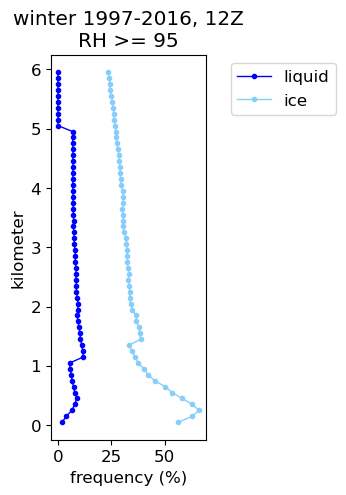

In [7]:
#===========================
rh_thresh = 95 #percent
#===========================


fig, ax = plt.subplots(figsize=(2,5))

# liquid
rh_freq = 100*np.nansum(np.nansum(all_RH_liq>=rh_thresh, axis=1), axis=1)/np.nansum(np.nansum(np.isnan(all_RH_liq)==False, axis=1), axis=1)
ax.plot(rh_freq, new_H, lw = 1, c='blue', marker='.', label='liquid')

# ice
rh_freq = 100*np.nansum(np.nansum(all_RH_ice>=rh_thresh, axis=1), axis=1)/np.nansum(np.nansum(np.isnan(all_RH_liq)==False, axis=1), axis=1)
ax.plot(rh_freq, new_H, lw = 1, c='lightskyblue', marker='.', label='ice')

assert len(hours) == 1, 'error in title with multiple hours'
ax.set_title(f'{season} {years[0]}-{years[-1]}, {hours[0]}Z\nRH >= {rh_thresh}')
ax.set_xlabel('frequency (%)')

plt.legend(loc=9,bbox_to_anchor=(1.5,1))

# save
fig.savefig(f'./figures/RH{rh_thresh}_freq_{season}_{years[0]}-{years[-1]}.png', 
            transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)



#### Trying to understand why winter distribution looks strange between 1-5 km in vs of data

Text(0, 0.5, 'height (km)')

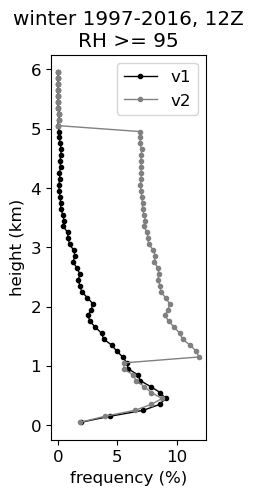

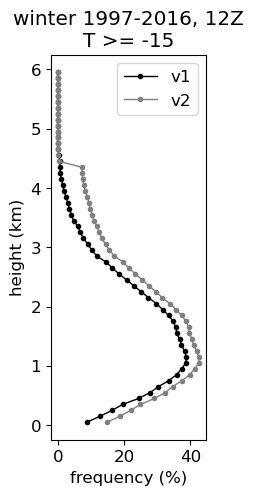

In [9]:

#=================
season = 'winter'
rh_thresh = 95
T_thresh = -15
#=================


# RH FIGURE
#------------
fig, ax = plt.subplots(figsize=(2,5))

# v1
ds1 = xr.open_dataset(f'./data/{season}_1997-2016_v1.nc')
rh_freq = 100*np.nansum(np.nansum(ds1.RH>=rh_thresh, axis=1), axis=1)/np.nansum(np.nansum(np.isnan(ds1.RH)==False, axis=1), axis=1)
ax.plot(rh_freq, ds1.h, lw = 1, c='black', marker='.', label='v1')

# v2
ds2 = xr.open_dataset(f'./data/{season}_1997-2016_v2.nc')
rh_freq = 100*np.nansum(np.nansum(ds2.RH_liq>=rh_thresh, axis=1), axis=1)/np.nansum(np.nansum(np.isnan(ds2.RH_liq)==False, axis=1), axis=1)
ax.plot(rh_freq, ds2.h, lw = 1, c='gray', marker='.', label='v2')

plt.legend()
assert len(hours) == 1, 'error in title with multiple hours'
ax.set_title(f'{season} {years[0]}-{years[-1]}, {hours[0]}Z\nRH >= {rh_thresh}')
ax.set_xlabel('frequency (%)')
ax.set_ylabel('height (km)')


# RH FIGURE
#------------
fig, ax = plt.subplots(figsize=(2,5))

# v1
ds1 = xr.open_dataset(f'./data/{season}_1997-2016_v1.nc')
T_freq = 100*np.nansum(np.nansum(ds1.T>=T_thresh, axis=1), axis=1)/np.nansum(np.nansum(np.isnan(ds1.T)==False, axis=1), axis=1)
ax.plot(T_freq, ds1.h, lw = 1, c='black', marker='.', label='v1')

# v2
ds2 = xr.open_dataset(f'./data/{season}_1997-2016_v3.nc')
T_freq = 100*np.nansum(np.nansum(ds2.T>=T_thresh, axis=1), axis=1)/np.nansum(np.nansum(np.isnan(ds2.T)==False, axis=1), axis=1)
ax.plot(T_freq, ds2.h, lw = 1, c='gray', marker='.', label='v2')

plt.legend()
assert len(hours) == 1, 'error in title with multiple hours'
ax.set_title(f'{season} {years[0]}-{years[-1]}, {hours[0]}Z\nT >= {T_thresh}')
ax.set_xlabel('frequency (%)')
ax.set_ylabel('height (km)')
